# Compare SEMITONES top scoring genes to genes selected by the variogram method in Seurat

## 1. Set up the notebook

### a. Load packages

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import sparse, io

from SEMITONES.cell_selection import from_2D_embedding
from SEMITONES.support_funcs import pairwise_similarities
from SEMITONES.enrichment_scoring import calculate_escores, permute

from sklearn.preprocessing import scale

## 2. Load the data

### a. The spot coordinates

In [3]:
coords = pd.read_csv("../data/raw/10X_spatial_musbrain_ant1_coords.txt",
                     sep="\t")
coords = coords.replace(",", ".", regex=True)
coords = coords.astype(float)

([], <a list of 0 Text yticklabel objects>)

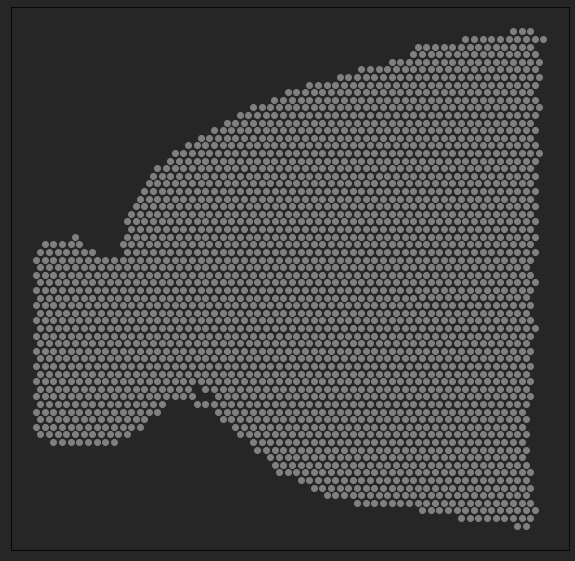

In [4]:
# plot to check the coordinate orientation
fig = plt.figure(figsize=(10, 10))
plt.scatter(x=coords.imagecol, y=-coords.imagerow, color="grey")
plt.gca().set_facecolor("#262626")  # set inner background colour
fig.patch.set_facecolor("#262626")  # set outer background colour
plt.xticks([])
plt.yticks([])

## 3. Select reference cells
This is reproducible from paper_12_spatial_mouse_brain_SEMITONES.ipynb

In [5]:
r_cells = from_2D_embedding(coords.values, g=(6, 6), d=0.2)

([], <a list of 0 Text yticklabel objects>)

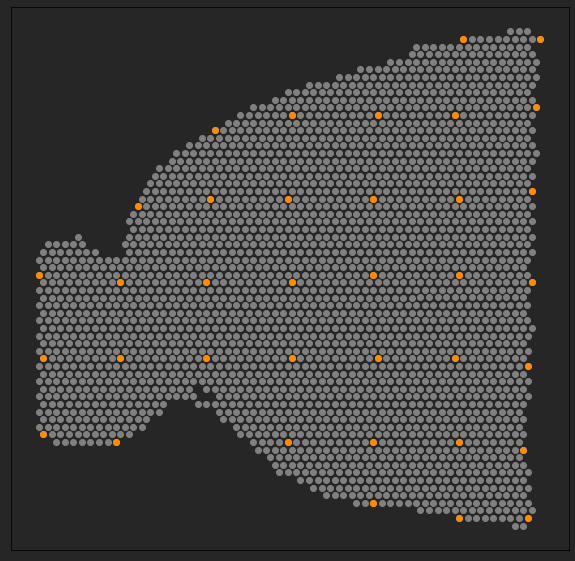

In [6]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(x=coords.imagecol, y=-coords.imagerow, color="grey")
plt.scatter(x=coords.imagecol[r_cells], y=-coords.imagerow[r_cells],
            color="darkorange")
plt.gca().set_facecolor("#262626")  # set inner background colour
fig.patch.set_facecolor("#262626")  # set outer background colour
plt.xticks([])
plt.yticks([])

## 4. Do SEMITONES significance testing

### a. Compute the permutation null distributions

In [7]:
# load data
X = pd.read_csv("../data/processed/10X_spatial_musbrain_ant1_norm.txt", sep="\t",
                low_memory=False)
X = X.replace(",", ".", regex=True)
X = X.astype(float)

In [8]:
X = X.T  # transpose to cells in indices and genes in columns

In [9]:
# scale the data and make dataframe
X = pd.DataFrame(scale(X, with_mean=False), index=X.index,
                 columns=X.columns)

In [10]:
genes, cells = X.columns, X.index  # get gene and cell names
X = sparse.csr_matrix(X)  # use sparse matrix

In [11]:
P = permute(X)  # get permuted vectors

In [12]:
S = pairwise_similarities(coords.values, r_cells, metric="rbf",
                          metric_params={"gamma": 1e-3})

In [13]:
# calculate the pscores
pscores = calculate_escores(P, query=r_cells, S=S,
                            scale_exp=False, ncpu=1, n_chunks=30)

Start enrichment scoring
Enrichment scoring complete


In [14]:
pscores.columns = cells[r_cells]  # reference cell columns

In [15]:
# save the pscores
pscores.to_csv("../data/processed/10X_spatial_pscores_grid_rbf_1e-3.txt",
               sep="\t")

In [16]:
# load the enrichment scores
escores = pd.read_csv(
    "../data/processed/10X_spatial_escores_grid_rbf_1e-3.txt", sep="\t",
    index_col=0)

### b. Select the top 100 SEMITONES genes across cells

In [17]:
vario_genes = pd.read_csv("spatially_variable_features_Seurat.txt",
                          header=None).values.flatten().tolist()

In [18]:
top100 = np.abs(escores).max(1).sort_values(ascending=False).index[:100]

In [19]:
notvario = [gene for gene in top100 if not gene in vario_genes]

In [20]:
notvario

['6430628N08Rik', 'Magel2', 'Peg10', 'Glra3']

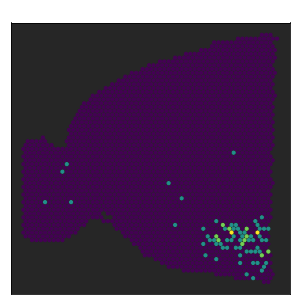

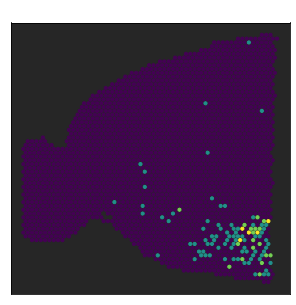

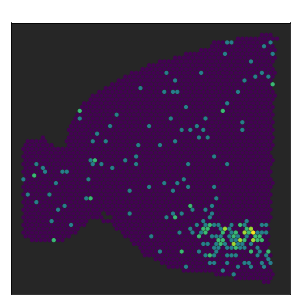

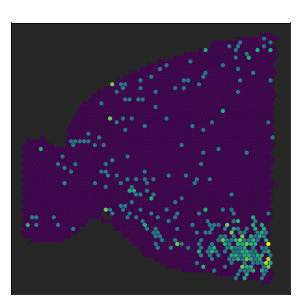

In [21]:
for gene in notvario:
    gene_exp = X[:, list(escores.index).index(gene)]
    plt.figure(figsize=(5, 5))
    plt.scatter(coords.imagecol, -coords.imagerow,
                c=gene_exp.A.ravel(), s=10)
    ax = plt.gca()
    ax.set_facecolor("#262626")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(gene, color="white")
    plt.show()